In [5]:
import torch
import numpy as np
import math

import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [3]:
!pip install torch

  Using cached torch-2.8.0-cp311-cp311-manylinux_2_28_x86_64.whl.metadata (30 kB)
Using cached torch-2.8.0-cp311-cp311-manylinux_2_28_x86_64.whl (888.1 MB)


In [4]:
path = '../full_dataset.csv'

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Implement determinism. Set a fixed value for random seed so that when the parameters are initialized, they are initialized same across all experiments.
torch.manual_seed(42)

# If you are using CUDA, also set the seed for it
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Set the seed for NumPy
np.random.seed(42)

Using device: cuda


In [7]:
class RiverData(torch.utils.data.Dataset):
    
    def __init__(self, df, target, datecol, seq_len, pred_len):
        self.df = df
        self.datecol = datecol
        self.target = target
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.setIndex()
        

    def setIndex(self):
        self.df.set_index(self.datecol, inplace=True)
    

    def __len__(self):
        return len(self.df) - self.seq_len - self.pred_len


    def __getitem__(self, idx):
        if len(self.df) <= (idx + self.seq_len+self.pred_len):
            raise IndexError(f"Index {idx} is out of bounds for dataset of size {len(self.df)}")
        df_piece = self.df[idx:idx+self.seq_len].values
        feature = torch.tensor(df_piece, dtype=torch.float32)
        label_piece = self.df[self.target][idx + self.seq_len:  idx+self.seq_len+self.pred_len].values
        label = torch.tensor(label_piece, dtype=torch.float32)
        return (feature, label) 

In [8]:
from sklearn.preprocessing import StandardScaler


In [9]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Read CSV
df = pd.read_csv('full_dataset.csv')

# Ensure DATE is datetime
df['DATE'] = pd.to_datetime(df['DATE'])

# Columns to scale (excluding 'DATE' and 'precipitation')
exclude_columns = ['DATE', 'precip_accum_one_hour']
columns_to_scale = [col for col in df.columns if col not in exclude_columns]

# Scale selected columns with MinMaxScaler
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df[columns_to_scale])
df_scaled = pd.DataFrame(scaled_data, columns=columns_to_scale)

# Scale 'precipitation' using 7-day moving average
df_scaled['precip_accum_one_hour'] = df['precip_accum_one_hour'].rolling(window=7, min_periods=1).mean()

# Add DATE back without scaling
df_scaled['DATE'] = df['DATE']

# Optional: reorder to match original column order
df_scaled = df_scaled[df.columns]

# Assign back if needed
df = df_scaled


In [10]:
df.head()


,DATE,streamflow_cfs,precip_accum_one_hour,temperature,MOD10A1_061_NDSI_Snow_Cover,SPL3SMP_E_006_Soil_Moisture_Retrieval_Data_AM_soil_moisture,SPL3SMP_E_006_Soil_Moisture_Retrieval_Data_PM_soil_moisture_pm,VNP15A2H_002_Lai,drainage_area_km2,avg_elev_m,forest_cover_percent,avg_slope_percent,main_channel_length_km,main_channel_slope_m_km,mean_precip
0,2015-10-01 04:00:00,0.011799,0.0,0.673707,1.0,1.000000,1.000000,0.420290,0.207572,1.0,1.000000,1.000000,0.837576,1.0,1.000000
1,2015-10-01 04:00:00,0.001353,0.0,0.552737,1.0,0.441195,0.312292,0.086957,0.058269,0.0,0.376796,0.114379,0.164848,0.0,0.236986
2,2015-10-01 04:15:00,0.001353,0.0,0.550112,1.0,0.441195,0.312292,0.086957,0.058269,0.0,0.376796,0.114379,0.164848,0.0,0.236986
3,2015-10-01 04:15:00,0.011799,0.0,0.673707,1.0,1.000000,1.000000,0.420290,0.207572,1.0,1.000000,1.000000,0.837576,1.0,1.000000
4,2015-10-01 04:30:00,0.001353,0.0,0.548488,1.0,0.441195,0.312292,0.086957,0.058269,0.0,0.376796,0.114379,0.164848,0.0,0.236986


In [11]:
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

seq_len = 24
pred_len = 1
num_features = 14
num_layers = 1


common_args = ['precip_accum_one_hour', 'DATE', seq_len, pred_len]
train_dataset = RiverData(df[:train_size], *common_args)
val_dataset = RiverData(df[train_size: train_size+val_size], *common_args)
test_dataset = RiverData(df[train_size+val_size : len(df)], *common_args)

In [12]:
# Important parameters

BATCH_SIZE = 128 # keep as big as can be handled by GPU and memory
SHUFFLE = False # we don't shuffle the time series data
DATA_LOAD_WORKERS = 1 # it depends on amount of data you need to load
learning_rate = 1e-3

In [13]:
from torch.utils.data import DataLoader

common_args = {'batch_size': BATCH_SIZE, 'shuffle': SHUFFLE}
train_loader = DataLoader(train_dataset, **common_args)
val_loader = DataLoader(val_dataset, **common_args)
test_loader = DataLoader(test_dataset, **common_args)

In [14]:
class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, pos_enc_dropout, max_len=5000):
        super().__init__();
        self.dropout = torch.nn.Dropout(p=pos_enc_dropout)

        Xp = torch.zeros(max_len, d_model) # max_len x d_model
        position = torch.arange(0, max_len).unsqueeze(1) # max_len x 1

        # Generates an exponentially decreasing series of numbers
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model)) #length: d_model/2

        #Applying sine to even indices in the array; 2i
        Xp[:, 0::2] = torch.sin(position.float() * div_term)

        #Applying cosine to odd indices in the array; 2i + 1
        Xp[:, 1::2] = torch.cos(position.float() * div_term)

        Xp = Xp.unsqueeze(1)
        self.register_buffer('Xp', Xp)

    def forward(self, x):
        x  = x + self.Xp[:x.size(0)]
        return self.dropout(x)

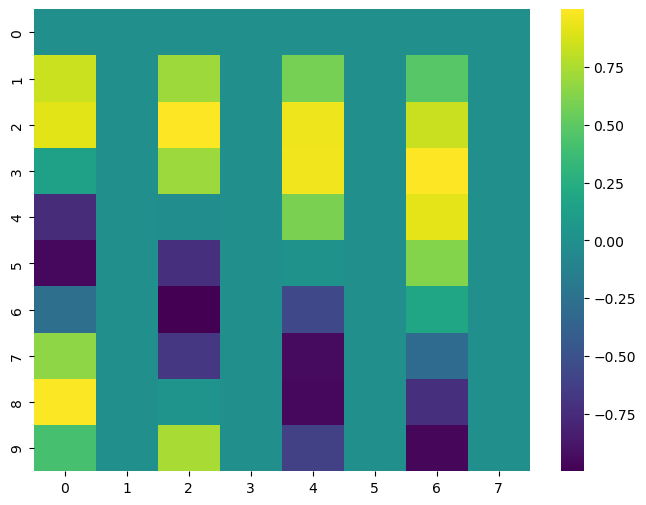

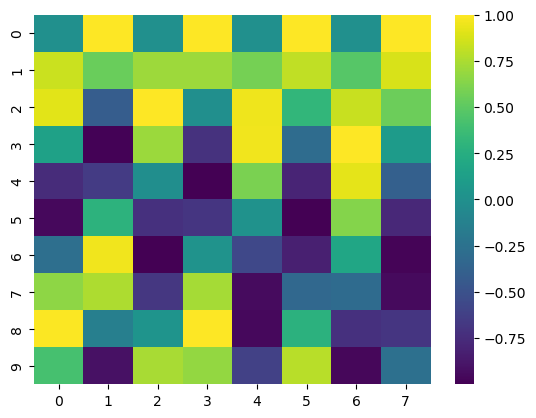

Positional encoding applied for our 3 timesteps


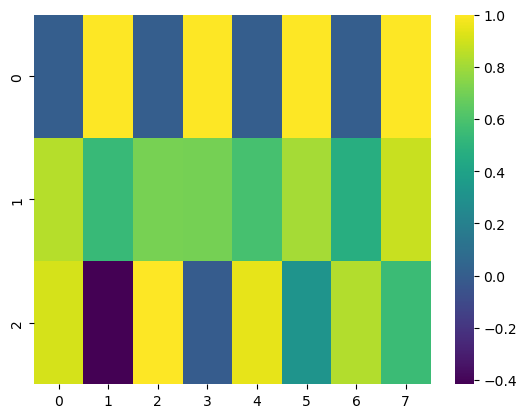

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import SymLogNorm

plt.figure(figsize=(8, 6))

xp = torch.zeros(10, 8)
maxlen = 10
position = torch.arange(0, 10).unsqueeze(1)
# print('position', position)
div_term = torch.exp(torch.arange(0, 8, 2)*(-math.log(9.0/8)))
# print('div_term', div_term)
xp[:, 0::2] = torch.sin(position.float() * div_term)
#evens
# print(xp)
# Generate the heatmap using seaborn
sns.heatmap(xp, cmap='viridis', annot=False)

# Display the plot
plt.show()
#odds
xp[:, 1::2] = torch.cos(position.float() * div_term)

sns.heatmap(xp, cmap='viridis', annot=False)

# Display the plot
plt.show()

print('Positional encoding applied for our 3 timesteps')
sns.heatmap(xp[:3], cmap='viridis', annot=False)

# Display the plot
plt.show()

In [16]:
class BasicTransformerNetwork(torch.nn.Module):
    
    def __init__(self, seq_len, pred_len, enc_layer_dropout, pos_enc_dropout):
        # call the constructor of the base class
        super().__init__()
        self.model_type = 'Transformer'
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.num_features = num_features

        # I don't think the embedding size should be this big. We will see.
        self.embedding_size = 128 #The features are converted to 128 embeddings
        self.num_layers = num_layers
        self.pos_encoder = PositionalEncoding(self.embedding_size, pos_enc_dropout, 10000)
        
        # dim_feedforward = 4 * d_model
        # layer_norm_eps: A very small number (epsilon) added to the denominator during the Layer Normalization calculation.
        self.encLayer = torch.nn.TransformerEncoderLayer(d_model=self.embedding_size, nhead=8, 
                                                 dim_feedforward=256, dropout=enc_layer_dropout, activation="relu", 
                                                 layer_norm_eps=1e-05, batch_first=True)
        
        self.transformerEnc = torch.nn.TransformerEncoder(self.encLayer, num_layers=self.num_layers)

        self.input_fc = torch.nn.Linear(self.num_features, self.embedding_size)
        
        self.prediction_head = torch.nn.Linear(self.embedding_size, self.pred_len)

        # Create causal mask
        self.register_buffer('causal_mask', self._generate_causal_mask(seq_len))


    def _generate_causal_mask(self, seq_len):
        """
        Generate causal mask for transformer encoder.
        Returns upper triangular matrix with -inf in upper triangle (excluding diagonal)
        """
        mask = torch.triu(torch.full((seq_len, seq_len), float('-inf')), diagonal=1)
        return mask

    
    def forward(self, x):
        x = self.input_fc(x) * np.sqrt(self.embedding_size)
        x = self.pos_encoder(x)
        out = self.transformerEnc(x, mask=self.causal_mask)
        last_embedding = out[:, -1, :]
        prediction = self.prediction_head(last_embedding)
        prediction = prediction.squeeze(-1)
        return prediction
# Note that the gradients are stored inside the FC layer objects
# For each training example we need to get rid of these gradients

In [17]:
model = BasicTransformerNetwork(3, 1, 0.1, 0.1)

In [18]:
#input 4 x 7, batch size 14
x = torch.Tensor(np.random.random((4, 3, 14)))#change the last based on input
x

tensor([[[0.3745, 0.9507, 0.7320, 0.5987, 0.1560, 0.1560, 0.0581, 0.8662,
          0.6011, 0.7081, 0.0206, 0.9699, 0.8324, 0.2123],
         [0.1818, 0.1834, 0.3042, 0.5248, 0.4319, 0.2912, 0.6119, 0.1395,
          0.2921, 0.3664, 0.4561, 0.7852, 0.1997, 0.5142],
         [0.5924, 0.0465, 0.6075, 0.1705, 0.0651, 0.9489, 0.9656, 0.8084,
          0.3046, 0.0977, 0.6842, 0.4402, 0.1220, 0.4952]],

        [[0.0344, 0.9093, 0.2588, 0.6625, 0.3117, 0.5201, 0.5467, 0.1849,
          0.9696, 0.7751, 0.9395, 0.8948, 0.5979, 0.9219],
         [0.0885, 0.1960, 0.0452, 0.3253, 0.3887, 0.2713, 0.8287, 0.3568,
          0.2809, 0.5427, 0.1409, 0.8022, 0.0746, 0.9869],
         [0.7722, 0.1987, 0.0055, 0.8155, 0.7069, 0.7290, 0.7713, 0.0740,
          0.3585, 0.1159, 0.8631, 0.6233, 0.3309, 0.0636]],

        [[0.3110, 0.3252, 0.7296, 0.6376, 0.8872, 0.4722, 0.1196, 0.7132,
          0.7608, 0.5613, 0.7710, 0.4938, 0.5227, 0.4275],
         [0.0254, 0.1079, 0.0314, 0.6364, 0.3144, 0.5086, 0.9076,

In [19]:
model.forward(x)

tensor([-0.4938,  0.2425,  0.1233,  0.1759], grad_fn=<SqueezeBackward1>)

In [20]:
print(torch.__version__)

2.8.0+cu128


In [21]:
learning_rate = 0.0012545904902955352
pos_enc_dropout = 0.11787907740395862
enc_layer_dropout = 0.3069555935064027
weight_decay = 0.00040808881865365666

model = BasicTransformerNetwork(seq_len, pred_len, pos_enc_dropout, enc_layer_dropout)
model = model.to(device)
loss = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [22]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 267009


In [23]:
for i, (f,l) in enumerate(train_loader):
    print('features shape: ', f.shape)
    print('labels shape: ', l.shape)
    break

features shape:  torch.Size([128, 24, 14])
labels shape:  torch.Size([128, 1])


In [24]:
# define metrics
import numpy as np
import matplotlib.pyplot as plt
epsilon = np.finfo(float).eps

def wape_function(y, y_pred):
    """Weighted Average Percentage Error metric in the interval [0; 100]"""
    y = np.array(y)
    y_pred = np.array(y_pred)
    nominator = np.sum(np.abs(np.subtract(y, y_pred)))
    denominator = np.add(np.sum(np.abs(y)), epsilon)
    wape = np.divide(nominator, denominator) * 100.0
    return wape

def nse_function(y, y_pred):
    y = np.array(y)
    y_pred = np.array(y_pred)
    return (1-(np.sum((y_pred-y)**2)/np.sum((y-np.mean(y))**2)))


def evaluate_model(model, data_loader, plot=False):
    # following line prepares the model for evaluation mode. It disables dropout and batch normalization if they have 
    # are part of the model. For our simple model, it's not necessary. Still, we're going to use it.

    model.eval()
    all_outputs = torch.empty(0, pred_len)
    all_labels = torch.empty(0, pred_len)
    for inputs, labels in data_loader:
        inputs = inputs.to(device)
        with torch.no_grad():
            outputs = model(inputs).detach().cpu().unsqueeze(1)
        all_outputs = torch.vstack((all_outputs, outputs))
        all_labels = torch.vstack((all_labels, labels))
   
    avg_val_loss = loss(all_outputs, all_labels)
    nse = nse_function(all_labels.numpy(), all_outputs.numpy())
    wape = wape_function(all_labels.numpy(), all_outputs.numpy())
        
    print(f'NSE : {nse}', end=' ')
    print(f'WAPE : {wape}', end=' ')
    print(f'Validation Loss: {avg_val_loss}')
    
    model.train()

    if plot:
        plt.figure(figsize=(16, 6))
        plt.plot(np.array(all_labels.cpu()[:10000]), color='green', label='observations')
        plt.plot(np.array(all_outputs.cpu()[:100000]), color='red', linestyle='-', label='predictions')
        metrics_text = f"NSE: {nse:.3f}\nWAPE: {wape:.3f}" 
        plt.text(0.28, 0.97, metrics_text, transform=plt.gca().transAxes, 
        fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        plt.legend()
        plt.show()
    
    return avg_val_loss


In [25]:
num_epochs = 200
best_val_loss = float('inf')
patience = 3

for epoch in range(num_epochs):
    epoch_loss = []
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs).unsqueeze(1)
        loss_val = loss(outputs, labels)

        # calculate gradients for back propagation
        loss_val.backward()

        # update the weights based on the gradients
        optimizer.step()

        # reset the gradients, avoid gradient accumulation
        optimizer.zero_grad()
        epoch_loss.append(loss_val.item())

    avg_train_loss = sum(epoch_loss)/len(epoch_loss)
    print(f'Epoch {epoch+1}: Traning Loss: {avg_train_loss}', end=' ')
    avg_val_loss = evaluate_model(model, val_loader)

    # Check for improvement
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        # Save the best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve == patience:
            print('Early stopping!')
            # Load the best model before stopping
            model.load_state_dict(torch.load('best_model.pth'))
            break

Epoch 1: Traning Loss: 0.04035096756912918 NSE : 0.5876337289810181 WAPE : 134.4716416289682 Validation Loss: 0.009545758366584778
Epoch 2: Traning Loss: 0.04385882581128827 NSE : 0.5143997073173523 WAPE : 79.96018524688479 Validation Loss: 0.011241032741963863
Epoch 3: Traning Loss: 0.03916418281692203 NSE : 0.6304333806037903 WAPE : 133.48005498668522 Validation Loss: 0.008555001579225063
Epoch 4: Traning Loss: 0.03760982953449445 NSE : 0.6210096776485443 WAPE : 101.36425223784455 Validation Loss: 0.008773147128522396
Epoch 5: Traning Loss: 0.03543777589124978 NSE : 0.6340192258358002 WAPE : 110.96430307831653 Validation Loss: 0.00847199372947216
Epoch 6: Traning Loss: 0.03749447943182245 NSE : 0.5883794724941254 WAPE : 120.6417869191908 Validation Loss: 0.00952849630266428
Epoch 7: Traning Loss: 0.039931440044662425 NSE : 0.5901012122631073 WAPE : 120.67204440396951 Validation Loss: 0.009488638490438461
Epoch 8: Traning Loss: 0.037227887299956804 NSE : 0.49908411502838135 WAPE : 145

NSE : 0.769414484500885 WAPE : 65.871329083031 RMSE : 0.12175805866718292 MAE : 0.033281367272138596 Validation Loss: 0.014825025573372841


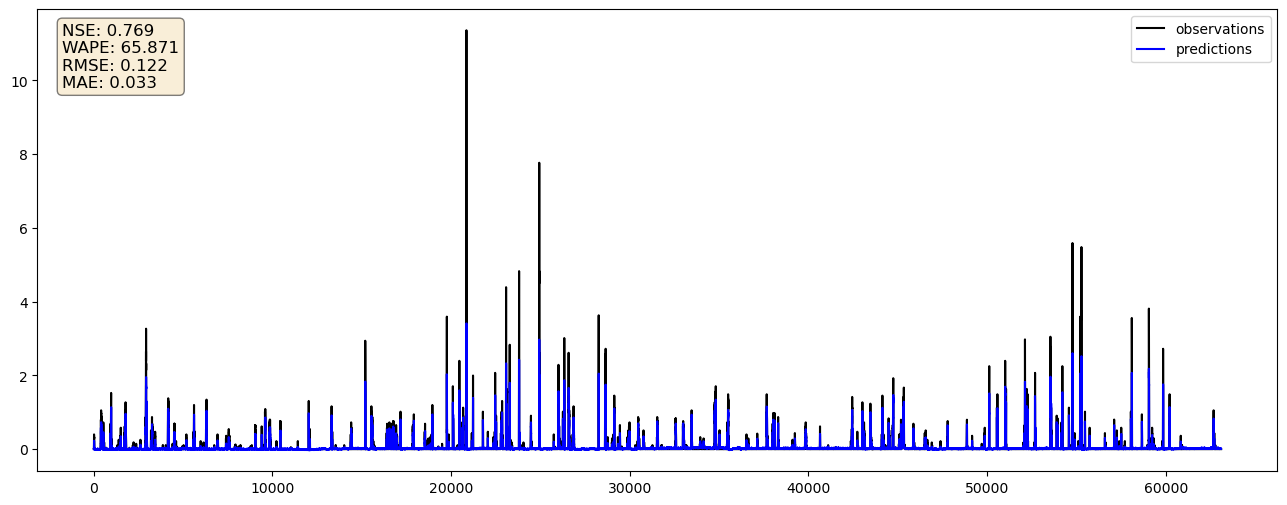

tensor(0.0148)

In [148]:
evaluate_model(model, test_loader, plot=True)